In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision.transforms.functional as TF
from text3d2video.artifacts.animation_artifact import AnimationArtifact

torch.set_grad_enabled(False)

anim_artifact = 'rumba:latest'
anim_artifact = 'backflip:latest'
anim_artifact = 'human_rotation_90:latest'

# read animation
n_frames = 5
animation = AnimationArtifact.from_wandb_artifact_tag(anim_artifact)
cams, mesh_frames = animation.cams_and_frames(n_frames)
uv_verts, uv_faces = animation.texture_data()

In [2]:
import torch
from diffusers.models import ControlNetModel
from diffusers.schedulers import DPMSolverMultistepScheduler

from text3d2video.generative_rendering.generative_rendering_pipeline import (
    GenerativeRenderingPipeline,
)

device = torch.device("cuda")
dtype = torch.float16

sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"

controlnet = ControlNetModel.from_pretrained(controlnet_repo, torch_dtype=dtype).to(
    device
)

pipe: GenerativeRenderingPipeline = GenerativeRenderingPipeline.from_pretrained(
    sd_repo, controlnet=controlnet, torch_dtype=dtype
).to(device)

pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:13<00:00,  7.34s/it]


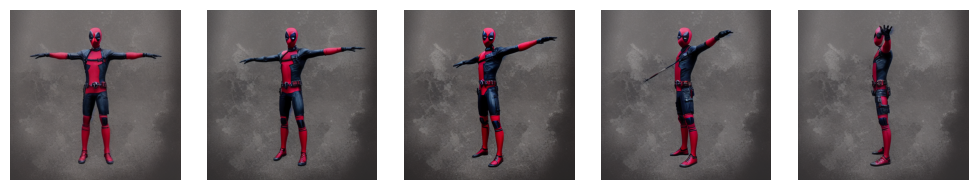

In [15]:
from text3d2video.artifacts.gr_data import GrSaveConfig
from text3d2video.generative_rendering.configs import GenerativeRenderingConfig, NoiseInitializationConfig, NoiseInitializationMethod
from text3d2video.ipython_utils import display_ims

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    # "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    seed=0,
    resolution=512,
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.5,
    chunk_size=5,
    num_keyframes=4,
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

gr_save_cfg = GrSaveConfig(
    enabled=True,
    n_frames=5,
    n_timesteps=5,
    save_latents=True,
    save_q=True,
    save_k=True,
    save_v=True,
    out_artifact="gr_data",
    module_paths=module_paths,
)


noise_config = NoiseInitializationConfig(
    method=NoiseInitializationMethod.UV,
)
noise_config.uv_texture_res = 64

prompt = "Deadpool Dancing"

video_frames = pipe(
    prompt,
    mesh_frames,
    cams,
    uv_verts,
    uv_faces,
    generative_rendering_config=gr_config,
    noise_initialization_config=noise_config,
    gr_save_config=gr_save_cfg,
)

art = pipe.gr_data_artifact

display_ims(video_frames)

In [5]:
frame_indices = art.diffusion_data.save_frame_indices
time_steps = art.diffusion_data.save_step_times
modules = art.diffusion_data.save_module_paths

In [6]:
from text3d2video.sd_feature_extraction import read_layer_paths

enc_layers, mid_layers, dec_layers = read_layer_paths(modules)

In [7]:
from text3d2video.video_util import pil_frames_to_clip
from PIL import Image

def latents_video(latents):
    frames = []
    for latent in latents:
        frame = TF.to_pil_image(latent[0:3].cpu())
        frame = frame.resize((512, 512), Image.NEAREST)
        frames.append(frame)
    return frames


frame_latents = art.read_latents_at_timestep(time_steps[0])
vid = latents_video(frame_latents)
pil_frames_to_clip(vid).ipython_display()

  return Tensor(dset)



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [8]:
from text3d2video.attention_visualization import reshape_concatenated
from text3d2video.feature_visualization import reduce_feature_map


time = time_steps[-1]
frame = frame_indices[0]

keys = []
vals = []
for module in dec_layers:
    path = module.module_path()
    layer_res = module.layer_resolution(pipe.unet)
    key = art.attn_writer.read_key(time, frame, path)
    val = art.attn_writer.read_val(time, frame, path)

    key_square = reshape_concatenated(key, layer_res)
    key_square_rgb = reduce_feature_map(key_square)

    val_square = reshape_concatenated(val, layer_res)
    val_square_rgb = reduce_feature_map(val_square)

    keys.append(key_square_rgb) 
    vals.append(val_square_rgb)

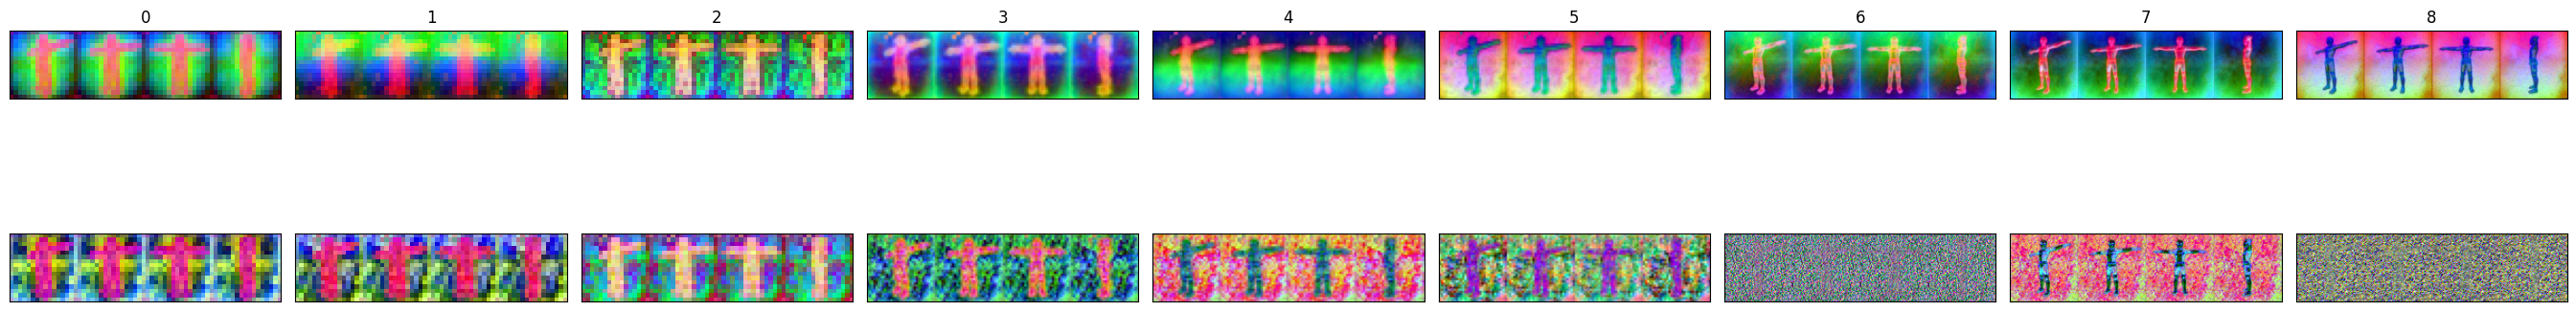

In [9]:
from text3d2video.ipython_utils import display_ims_grid

col_titles = [l.unet_path_index() for l in dec_layers]

display_ims_grid([keys, vals], transpose_images=False, scale=3, col_titles=col_titles)

In [10]:
frame = frame_indices[0]
time = time_steps[-1]
layer = dec_layers[-1]
module_path = layer.module_path()

qry = art.attn_writer.read_qry(time, frame, module_path)
key = art.attn_writer.read_key(time, frame, module_path)
val = art.attn_writer.read_val(time, frame, module_path)

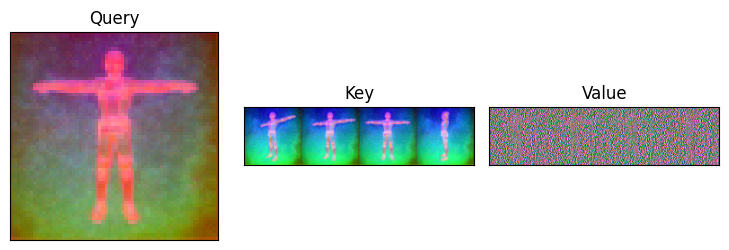

In [11]:
from einops import rearrange

from text3d2video.attention_visualization import reshape_concatenated, split_heads
from text3d2video.feature_visualization import RgbPcaUtil, reduce_feature_map
from text3d2video.ipython_utils import display_ims, display_ims_grid

head_idx = 2

qry_mh = split_heads(qry.unsqueeze(0))
key_mh = split_heads(key.unsqueeze(0))
val_mh = split_heads(val.unsqueeze(0))

qry_head = qry_mh[0, :, head_idx, :]
key_head = key_mh[0, :, head_idx, :]
val_head = val_mh[0, :, head_idx, :]

layer_res = layer.layer_resolution(pipe.unet)
qry_square = rearrange(qry_head, "(h w) d -> d h w", h=layer_res)
key_square = reshape_concatenated(key_head, layer_res)
val_square = reshape_concatenated(val_head, layer_res)

qk_features = torch.cat([qry_head, key_head], dim=0)
pca_qk = RgbPcaUtil.init_from_features(qk_features)

val_rgb = reduce_feature_map(val_square)
qry_rgb = pca_qk.feature_map_to_rgb_pil(qry_square)
key_rgb = pca_qk.feature_map_to_rgb_pil(key_square)

display_ims_grid([[qry_rgb, key_rgb, val_rgb]], col_titles=["Query", "Key", "Value"])

In [12]:
vert_features = art.gr_writer.read_vertex_features(time, module_path)

gr_data/time_200/up_blocks.3.attentions.2.transformer_blocks.0.attn1/vert_features


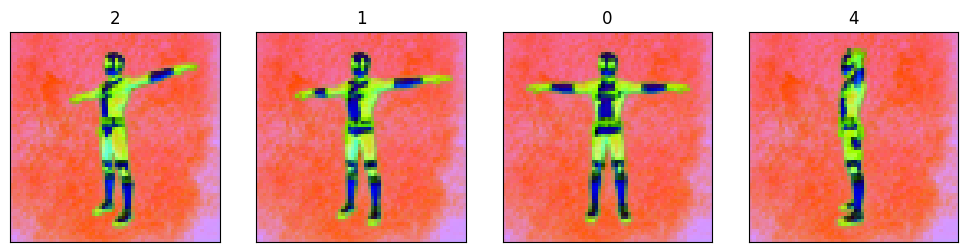

In [13]:
from text3d2video.ipython_utils import display_ims_grid

kf_indices = art.gr_writer.read_kf_indices(time)
kf_features = art.gr_writer.read_kf_post_attn(time, module_path)[0]

kf_features_flat = rearrange(kf_features, "n c h w -> (n h w) c")
pca = RgbPcaUtil.init_from_features(kf_features_flat)

kf_features_pil = [pca.feature_map_to_rgb_pil(fmap) for fmap in kf_features]
display_ims_grid([kf_features_pil], col_titles=[int(i) for i in kf_indices])

In [14]:
from torch import Tensor
from text3d2video.camera_placement import turntable_cameras
from text3d2video.rendering import make_feature_renderer
from pytorch3d.renderer import TexturesVertex
from pytorch3d.structures import Meshes

vert_ft = vert_features[0]

def view_vert_features(
    mesh: Meshes, vert_features: Tensor, pca=None, render_res=200, n_frames=25
):
    if pca is None:
        pca = RgbPcaUtil.init_from_features(vert_features)

    # dimensionality reduce
    vert_ft_rgb = pca.features_to_rgb(vert_features)
    vert_ft_rgb = Tensor(vert_ft_rgb)

    # turntable cameras
    cameras = turntable_cameras(n_frames, 2)

    # render
    renderer = make_feature_renderer(cameras, render_res, "cuda")
    render_mesh = mesh.clone()
    render_mesh = render_mesh.extend(len(cameras))
    render_mesh.textures = TexturesVertex(
        vert_ft_rgb.expand(len(cameras), -1, -1).cuda()
    )

    renders = renderer(render_mesh)
    renders_pil = [TF.to_pil_image(rearrange(r, "h w c -> c h w")) for r in renders]

    return renders_pil


unposed = animation.load_unposed_mesh()
kf_index = int(kf_indices[0])
# unposed = mesh_frames[kf_index]

frames = view_vert_features(unposed, vert_ft, pca, render_res=512, n_frames=25)
pil_frames_to_clip(frames, duration=1.5).ipython_display()

  warnings.warn("No mtl file provided")



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
